In [22]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
from matplotlib import pyplot as plt
import sys
sys.path.append('/Users/magdalenastrauss/Documents/GPclust')
sys.path.append('/Users/magdalenastrauss/Documents/GPy')
sys.path.append('/anaconda/lib/python3.6/site-packages')
import numpy as np
import os
import GPy
import GPclust

Change the root directory below for your system

In [23]:
rootdir = '../scratch'#where 
def datafile(filename):
    return os.path.join(rootdir, filename)

Define functions to load data

In [24]:
def load_data(expr_file, times_file):
    expression = np.loadtxt(datafile(expr_file), delimiter=',')
    times = np.loadtxt(datafile(times_file), delimiter=',')
    # remove genes with no variance
    std = expression.std(axis=1)
    nonzero_var = std != 0.
    expression = expression[nonzero_var]
    # normalize data row-wise
    expression -= expression.mean(axis=1)[:, np.newaxis]
    expression /= std[nonzero_var, np.newaxis]
    return expression, times

Define function to fit GPClust model

In [6]:
def fit_gpclust(underlying_variance, underlying_lengthscale,
                corruption_variance, corruption_lengthscale,
                noise_variance,
                expression,
                times,
                kernel=GPy.kern.Matern52,
                K=20,
                alpha=1.0):
    k_underlying = kernel(input_dim=1,
                          variance=underlying_variance,
                          lengthscale=underlying_lengthscale)
    k_corruption = \
        kernel(input_dim=1,
               variance=corruption_variance,
               lengthscale=corruption_lengthscale) + \
        GPy.kern.White(1, variance=noise_variance)
    m = GPclust.MOHGP(times.reshape(-1,1), k_underlying, k_corruption,
                      expression, K=20, prior_Z='DP', alpha=1.0)
    m.hyperparam_opt_interval = 1000 # how often to optimize the hyperparameters
    m.hyperparam_opt_args['messages'] = False # don't print optimization messages
    m.optimize()
    m.systematic_splits(verbose=False)  
    m.reorder()  # move biggest clusters to the top
    print(m)
    return m

In [25]:
def save_cluster_allocations(phi,fileName): 
    clusterAllocVector = np.zeros((1,phi.shape[0])) 
    for j in range(1,phi.shape[1]+1):
        k = j-1
        clusterAllocVector[0,np.argmax(phi,1)==k] = j
        np.savetxt(fileName, clusterAllocVector, delimiter=',')
    return clusterAllocVector     

# Shalek - deLorean

In [32]:
#The following may need several restarts to avoid local optima or solutions with all genes in only one cluster etc. 
#Due to this instability, it is possible that the clustering solution computed here is different from the one used in
#the GPseudoClust paper, which was based on several reruns to obtain a solution avoiding very short length scales, all genes 
#in only one cluster etc.
shalek_expr, shalek_deLorean_times = load_data("deLoreanShalek.csv", "deLoreanTShalek.csv")
m_shalek_deLorean = \
    fit_gpclust(underlying_variance=1.,
                underlying_lengthscale=12.,
                corruption_variance=.1,
                corruption_lengthscale=12.,
                noise_variance=.05,
                expression=shalek_expr,
                times=shalek_deLorean_times)

iteration 1 bound=-80092.3384746 grad=29472.4332999, beta=0
iteration 2 bound=-79822.8371932 grad=4623.42601556, beta=0.113339775962
iteration 4 bound=-85668.3050207 grad=39.2529566271, beta=0.0
iteration 5 bound=-80368.8715343 grad=0.0, beta=-0.0
vb converged (gtol)
iteration 7 bound=-16524.1190005 grad=344.311953867, beta=inf


 /Users/magdalenastrauss/Documents/GPclust/GPclust/collapsed_vb.py:164: RuntimeWarning:divide by zero encountered in double_scalars
 /Users/magdalenastrauss/Documents/GPclust/GPclust/collapsed_vb.py:167: RuntimeWarning:invalid value encountered in multiply


iteration 8 bound=-16521.5864936 grad=73.0235063057, beta=0.0884968942333
iteration 9 bound=-16458.7570638 grad=80.4105017016, beta=0.397858678274
iteration 10 bound=-16434.2763947 grad=97.5384402919, beta=18.8907994889
iteration 11 bound=-16426.7876289 grad=0.142773115632, beta=0.0
iteration 13 bound=-16423.6650465 grad=6.69083039847, beta=191.890910323
iteration 14 bound=-16421.4429488 grad=1.93296547446, beta=0.157685405162
iteration 15 bound=-16420.9775274 grad=1.65393076711, beta=0.0
iteration 16 bound=-16420.9617937 grad=0.0219687035427, beta=0.0215826995825
iteration 17 bound=-16420.9583555 grad=0.00413648467637, beta=0.262644688242
iteration 18 bound=-16420.9576525 grad=0.0010881771585, beta=0.0
iteration 19 bound=-16420.9575592 grad=0.000124789286461, beta=0.273431850875
iteration 20 bound=-16420.957545 grad=2.29795547632e-05, beta=0.0
iteration 21 bound=-16420.957544 grad=1.63307764009e-06, beta=0.212339541872
iteration 22 bound=-16420.9575437 grad=4.0908352001e-07, beta=0.0


In [33]:
save_cluster_allocations(m_shalek_deLorean.phi,'deLoreanGClShalek.csv')

array([[ 2.,  1.,  1.,  1.,  2.,  1.,  1.,  2.,  3.,  1.,  4.,  1.,  1.,
         3.,  2.,  4.,  3.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  2.,
         2.,  2.,  5.,  1.,  1.,  1.,  4.,  5.,  1.,  2.,  2.,  1.,  1.,
         6.,  3.,  3.,  1.,  1.,  1.,  3.,  1.,  1.,  4.,  1.,  2.,  1.,
         3.,  1.,  1.,  1.,  5.,  1.,  6.,  2.,  1.,  2.,  2.,  1.,  1.,
         1.,  1.,  1.,  4.,  3.,  1.,  2.,  5.,  4.]])

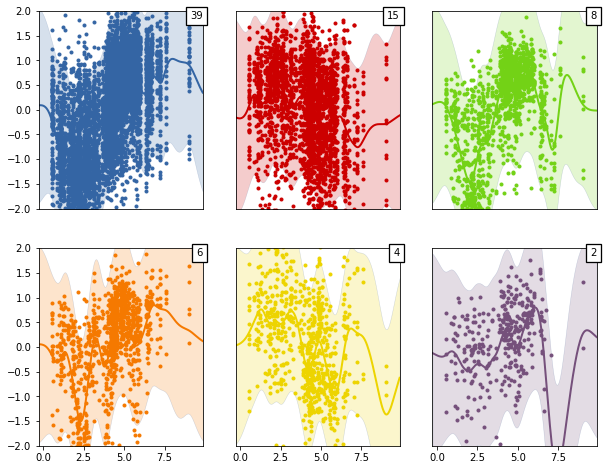

In [34]:
plt.figure(figsize=(10,8))
m_shalek_deLorean.plot(on_subplots=True, colour=True, in_a_row=False, newfig=False,
                     min_in_cluster=1, joined=False, ylim=(-2,2))

# Shalek - SLICER

In [29]:
#The following may need several restarts to avoid local optima or solutions with all genes in only one cluster etc. 
#Due to this instability, it is possible that the clustering solution computed here is different from the one used in
#the GPseudoClust paper, which was based on several reruns to obtain a solution avoiding very short length scales, all genes 
#in only one cluster etc.
shalek_expr, shalek_slicer_times = load_data("ShalekSLICER.csv", "pseudoTimesSLICER.csv")
m_shalek_slicer = \
    fit_gpclust(underlying_variance=1.,
                underlying_lengthscale=12.,
                corruption_variance=.1,
                corruption_lengthscale=12.,
                noise_variance=.05,
                expression=shalek_expr,
                times=shalek_slicer_times)

iteration 1 bound=-78308.806302 grad=10049.18566, beta=0
iteration 2 bound=-77952.0907374 grad=4627.49933037, beta=0.460533159206
iteration 4 bound=-81683.0875592 grad=172.448128786, beta=0.0
iteration 5 bound=-79228.6474328 grad=0.0, beta=-0.0
vb converged (gtol)
iteration 6 bound=-16586.2632234 grad=48.2680319349, beta=0.0


 /Users/magdalenastrauss/Documents/GPclust/GPclust/collapsed_vb.py:164: RuntimeWarning:divide by zero encountered in double_scalars


iteration 7 bound=-16582.1273886 grad=11.5462420018, beta=0.0419879265076
iteration 8 bound=-16563.8816346 grad=12.5315355034, beta=1.26351636008
iteration 9 bound=-16545.2845387 grad=33.0984398179, beta=1.60862240134
iteration 10 bound=-16533.9635491 grad=21.5948545722, beta=0.0
iteration 11 bound=-16523.6894917 grad=18.0628518798, beta=0.502971065623
iteration 13 bound=-16508.9119796 grad=35.7182947336, beta=1.40962474154
iteration 14 bound=-16501.5450262 grad=23.9520360387, beta=0.29901851825
iteration 16 bound=-16683.5553825 grad=8.32220418195, beta=0.0
iteration 17 bound=-16683.5553825 grad=1.95872091106e-25, beta=0.0
vb converged (ftol)
vb converged (gtol)

Name : MOHGP
Objective : 16185.518850754304
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  MOHGP.                 |            value  |  constraints  |  priors
  Mat52.variance         |    0.52462107912  |      +ve      |        
  Mat52.lengthscale      |    2.88682833674  |      

In [30]:
save_cluster_allocations(m_shalek_slicer.phi,'SLICER_GClShalek.csv')

array([[ 2.,  1.,  3.,  1.,  2.,  1.,  1.,  4.,  1.,  1.,  3.,  1.,  1.,
         1.,  4.,  1.,  1.,  1.,  1.,  1.,  1.,  3.,  1.,  4.,  1.,  2.,
         2.,  2.,  2.,  1.,  1.,  1.,  1.,  2.,  1.,  2.,  2.,  1.,  1.,
         5.,  1.,  1.,  1.,  3.,  1.,  1.,  1.,  1.,  3.,  1.,  2.,  1.,
         1.,  1.,  1.,  5.,  2.,  1.,  3.,  4.,  1.,  4.,  2.,  1.,  3.,
         1.,  1.,  1.,  1.,  1.,  1.,  2.,  2.,  1.]])

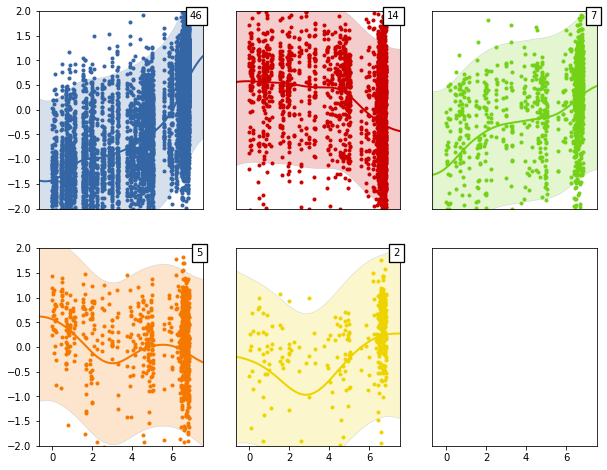

In [31]:
plt.figure(figsize=(10,8))
m_shalek_slicer.plot(on_subplots=True, colour=True, in_a_row=False, newfig=False,
                     min_in_cluster=1, joined=False, ylim=(-2,2))